In [2]:
!pip install gymnasium
!pip install matplotlib
!pip install gym
!pip install pygame

In [3]:
import gymnasium as gym
import matplotlib.pyplot as plt


# launch adventure environment with human rendering
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False,  render_mode="rgb_array")
env.reset()

number_of_actions = env.action_space.n

In [4]:

from llama_cpp import Llama
import numpy as np
import re


class LLM_Agent:

    def __init__(self):
        self.llm = Llama(model_path="../model/wizardLM-7B.ggmlv3.q4_1.bin", logits_all=True)

        # RL specific variables
        self.observations = []
        self.rewards = []


        self.memory = [] # extract previous epsiodes from game
        self.belief = [] # extract rules from game

    def set_action_space(self, action_space):
        self.action_space = action_space
        self.text_action_space = ', '.join(f"'{w}'" for w in action_space)
        print("action space: ", self.action_space)

    def get_action_prompt(self):
        prompt = (
            f"{self.character_prompt}"
            f"You can move in the following directions: {self.text_action_space}. "
            f"This is your last observation about positioning in the game {self.observations[-1]}. "
            # f"Please output one of the possible actions. "
            f"What direction do you want to move in? (please provide only the direction name, one word) "
            f"If you are unsure, please output one of the directions listed before as you are learning how to play. "
            # f"Choose an action to take: "
        )
        return prompt

    def set_character_prompt(self, character_prompt):
        self.character_prompt = character_prompt

    def generate(self, prompt):
        return self.llm(f"""{prompt}""", echo=True)
    
    def save_observation(self, observation):
        self.observations.append(observation)
        print(f"saved observation: {observation}")

    def save_reward(self, reward):
        self.rewards.append(reward)
    
    def generate_action(self, debug=False):
        print("generate_action")

        prompt = self.get_action_prompt()
        print(f"get_action_prompt: {prompt}")

        # TODO check actions are valid
        output = self.generate(prompt)
        print(f"generated output: {output}")
        
        generated_text = output['choices'][0]['text']
        print(f"generated text: {generated_text}")
        print("----------------------------------------------")
        
        # Find the direction chosen by the LLM_agent
        # generated_direction = re.search("'([^']+)'", generated_text)
        # print(f"Generated direction: {generated_direction.group(1)}")


        # TODO beam search would be better here or using raw logits
        

        # for all actions in action space check at which index it appears in the generated text
        # the action with the lowest index is the action we want to take
        text_index = 1000
        action_number = -1
        # times_found = -1
        print("---------------------------------------------------------------------------------------------------")
        print("Searching for action in generated text")
        for i, current_action in enumerate(self.action_space):
            # TODO - THSI is not working - make it look properly into the generated text
            action_index = generated_text.find(current_action, generated_text.find(" directions listed before as you are learning how to play.") + 1)
            print(f"action: {current_action}, index: {action_index}")
            if action_index != -1 and action_index < text_index:
                # times_found += 1
                # print(f"looking for action {current_action} in generated text ")
                # print(f"action found {times_found} times")
                print(f"action {current_action} found at index {action_index}")
                text_index = action_index
                action_number = i
                break


            # we want to skip the first occurence of the action
            # since the first time it is in the text is when we are giving instructions to the LLM
            # if times_found >= 1:
            #     text_index = action_index
            #     action_number = i
               
                

        if action_number == -1:
            # raise Exception("No action found in generated text")
            # print warning in red
            print("\033[91mNo action found in generated text\033[0m")
            # randomly select action
            action_number = np.random.randint(0, len(self.action_space))
        
        return action_number
    


In [5]:
# Some random notes / ideas

# multiple model controller, critic
# queue and planning
# long term memory 
# react 
# https://github.com/luca-medeiros/lang-segment-anything
# autonomous agents text us back if does know what to do and learn from it

In [6]:
# Your a video game player, your goal is to get the key and get out of the dungeon

agent = LLM_Agent()

# TODO check if this actually does anything
# env.action_space

action_space = [ 'left', 'down', 'right', 'up']
# action_space = env.action_space.seed(0)
# action_space = []

# for i in range(env.action_space.n):
#     print(i)
#     action_space.append(env.action_space.seed(i)[0])
#     print(action_space)


# print("action space: ", action_space)

# how can we get the agent to learn the action space
agent.set_action_space(action_space=action_space)

agent.set_character_prompt("We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. ")

action space:  ['left', 'down', 'right', 'up']


llama.cpp: loading model from ../model/wizardLM-7B.ggmlv3.q4_1.bin
llama_model_load_internal: format     = ggjt v3 (latest)
llama_model_load_internal: n_vocab    = 32001
llama_model_load_internal: n_ctx      = 512
llama_model_load_internal: n_embd     = 4096
llama_model_load_internal: n_mult     = 256
llama_model_load_internal: n_head     = 32
llama_model_load_internal: n_layer    = 32
llama_model_load_internal: n_rot      = 128
llama_model_load_internal: ftype      = 3 (mostly Q4_1)
llama_model_load_internal: n_ff       = 11008
llama_model_load_internal: n_parts    = 1
llama_model_load_internal: model size = 7B
llama_model_load_internal: ggml ctx size =    0.07 MB
llama_model_load_internal: mem required  = 5809.34 MB (+ 1026.00 MB per state)
.
llama_init_from_file: kv self size  =  256.00 MB
AVX = 0 | AVX2 = 0 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 0 | NEON = 1 | ARM_FMA = 1 | F16C = 0 | FP16_VA = 1 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 0 | VSX = 0 | 


observation: (0, {'prob': 1})
episode_reward: 0
=> TIMESTAMP [0]; EPISODE [0]<=
position: 0
saved observation: you are in position 0. This is the start of the game.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 0. This is the start of the game.. What direction do you want to move in? (please provide only the direction name) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-7480d4fd-1a61-40c0-ad70-1ffb90c77a29', 'object': 'text_completion', 'created': 1686081749, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 0. This is the start of the game.. What direction do you want to move in? (please provide only the direction name) If you are unsure, please output one of the directions listed before as you are learning how to play. \nI am an AI language model and I don't have a physical body to play a video game. However, I can help you understand the game mechanics and provide guidance on how to play based on your current position and goal.


llama_print_timings:        load time =  6907.03 ms
llama_print_timings:      sample time =    48.96 ms /    69 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  8492.76 ms /    51 tokens (  166.52 ms per token)
llama_print_timings:        eval time =  3716.76 ms /    68 runs   (   54.66 ms per token)
llama_print_timings:       total time = 12653.85 ms


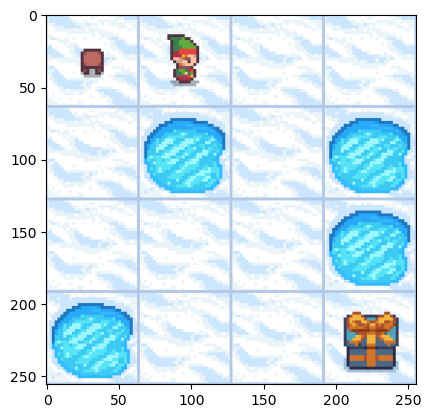

--------------------
obs: 1
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [1]; EPISODE [0]<=
position: 1
saved observation: you are in position 1. You moved from position 0. Your last action was to go right.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 1. You moved from position 0. Your last action was to go right.. What direction do you want to move in? (please provide only the direction name) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-57792816-1847-415c-90f7-8cf307929a19', 'object': 'text_completion', 'created': 1686081761, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 1. You moved from position 0. Your last action was to go right.. What direction do you want to move in? (please provide only the direction name) If you are unsure, please output one of the directions listed before as you are learning how to play. \nI would like to move forward (to the right).", 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 154, 'completion_tokens': 12, 'total_tokens': 166}


llama_print_timings:        load time =  6907.03 ms
llama_print_timings:      sample time =     9.23 ms /    13 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  3468.01 ms /    58 tokens (   59.79 ms per token)
llama_print_timings:        eval time =   648.91 ms /    12 runs   (   54.08 ms per token)
llama_print_timings:       total time =  4246.63 ms


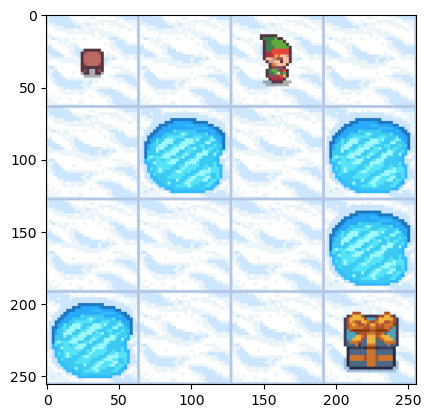

--------------------
obs: 2
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [2]; EPISODE [0]<=
position: 2
saved observation: you are in position 2. You moved from position 1. Your last action was to go right.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 2. You moved from position 1. Your last action was to go right.. What direction do you want to move in? (please provide only the direction name) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-1b37c9e3-8bcc-4c61-92e3-d59b9b73ccc0', 'object': 'text_completion', 'created': 1686081766, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 2. You moved from position 1. Your last action was to go right.. What direction do you want to move in? (please provide only the direction name) If you are unsure, please output one of the directions listed before as you are learning how to play. \nI am an AI language model and I don't have a physical body to play video games. However, I can simulate the game using a set of rules and make decisions based on that simulation. Fo


llama_print_timings:        load time =  6907.03 ms
llama_print_timings:      sample time =    47.07 ms /    66 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  3474.65 ms /    58 tokens (   59.91 ms per token)
llama_print_timings:        eval time =  3388.47 ms /    65 runs   (   52.13 ms per token)
llama_print_timings:       total time =  7219.77 ms


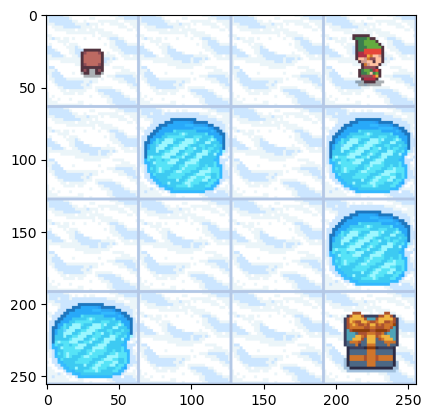

--------------------
obs: 3
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [3]; EPISODE [0]<=
position: 3
saved observation: you are in position 3. You moved from position 2. Your last action was to go right.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 3. You moved from position 2. Your last action was to go right.. What direction do you want to move in? (please provide only the direction name) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-7567b59c-0018-44c1-9028-dbaee83d437c', 'object': 'text_completion', 'created': 1686081773, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 3. You moved from position 2. Your last action was to go right.. What direction do you want to move in? (please provide only the direction name) If you are unsure, please output one of the directions listed before as you are learning how to play. \nI am an AI language model and I cannot have emotions or desires like a player. However, based on your information about the game, it seems that moving right would be the most logica


llama_print_timings:        load time =  6907.03 ms
llama_print_timings:      sample time =    43.75 ms /    61 runs   (    0.72 ms per token)
llama_print_timings: prompt eval time =  3461.52 ms /    58 tokens (   59.68 ms per token)
llama_print_timings:        eval time =  3518.65 ms /    60 runs   (   58.64 ms per token)
llama_print_timings:       total time =  7321.80 ms


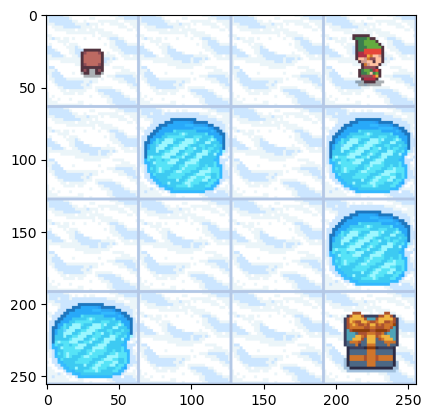

--------------------
obs: 3
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [4]; EPISODE [0]<=
position: 3
saved observation: you are still in position 3. You did not move. Your last action was to go right.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are still in position 3. You did not move. Your last action was to go right.. What direction do you want to move in? (please provide only the direction name) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-fd0362e1-a922-45c5-895d-494dbead94f4', 'object': 'text_completion', 'created': 1686081780, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are still in position 3. You did not move. Your last action was to go right.. What direction do you want to move in? (please provide only the direction name) If you are unsure, please output one of the directions listed before as you are learning how to play. \nI am an AI language model and I do not have a physical body to play a video game. However, based on your observation about being located in position 3 and wanting to reach down right, 


llama_print_timings:        load time =  6907.03 ms
llama_print_timings:      sample time =    42.35 ms /    59 runs   (    0.72 ms per token)
llama_print_timings: prompt eval time =  3629.91 ms /    60 tokens (   60.50 ms per token)
llama_print_timings:        eval time =  2945.13 ms /    58 runs   (   50.78 ms per token)
llama_print_timings:       total time =  6908.05 ms


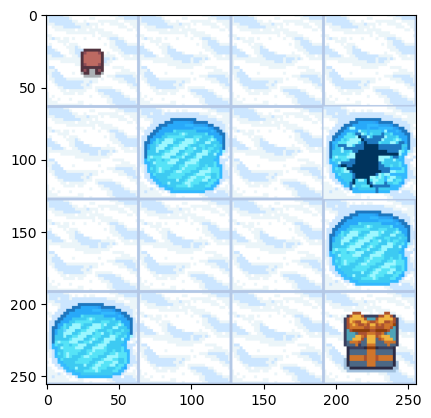

--------------------
obs: 7
reward: 0.0
terminated: True
truncated: False
info: {'prob': 1.0}
--------------------
Episode finished after 5 timesteps
observation: (0, {'prob': 1})
episode_reward: 0
=> TIMESTAMP [0]; EPISODE [1]<=
position: 0
saved observation: you are in position 0. You moved from position 3. Your last action was to go down.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 0. You moved from position 3. Your last action was to go down.. What direction do you want to move in? (please provide only the direction name) If you are unsure, please output one of the directions listed before as you are learning how to play

Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-fa266d04-3490-434e-9057-a625f08f9548', 'object': 'text_completion', 'created': 1686081787, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 0. You moved from position 3. Your last action was to go down.. What direction do you want to move in? (please provide only the direction name) If you are unsure, please output one of the directions listed before as you are learning how to play. \n\nAs an AI assistant, I don't have access to your current position or knowledge about the game you are playing. Therefore, I cannot accurately predict your desired movement direction


llama_print_timings:        load time =  6907.03 ms
llama_print_timings:      sample time =    37.08 ms /    52 runs   (    0.71 ms per token)
llama_print_timings: prompt eval time =  3327.86 ms /    61 tokens (   54.56 ms per token)
llama_print_timings:        eval time =  2677.94 ms /    51 runs   (   52.51 ms per token)
llama_print_timings:       total time =  6307.61 ms


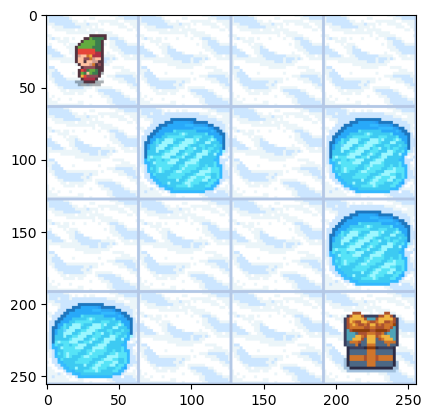

--------------------
obs: 0
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [1]; EPISODE [1]<=
position: 0
saved observation: you are still in position 0. You did not move. Your last action was to go left.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are still in position 0. You did not move. Your last action was to go left.. What direction do you want to move in? (please provide only the direction name) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-7712a97d-ca19-4491-b207-4956504b37b9', 'object': 'text_completion', 'created': 1686081794, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are still in position 0. You did not move. Your last action was to go left.. What direction do you want to move in? (please provide only the direction name) If you are unsure, please output one of the directions listed before as you are learning how to play. \nThe AI language model is currently in position 0 and has not taken any actions yet. Based on the information provided, the AI language model would like to move towards the direction 'do


llama_print_timings:        load time =  6907.03 ms
llama_print_timings:      sample time =    30.25 ms /    42 runs   (    0.72 ms per token)
llama_print_timings: prompt eval time =  3501.16 ms /    60 tokens (   58.35 ms per token)
llama_print_timings:        eval time =  2205.97 ms /    41 runs   (   53.80 ms per token)
llama_print_timings:       total time =  5959.61 ms


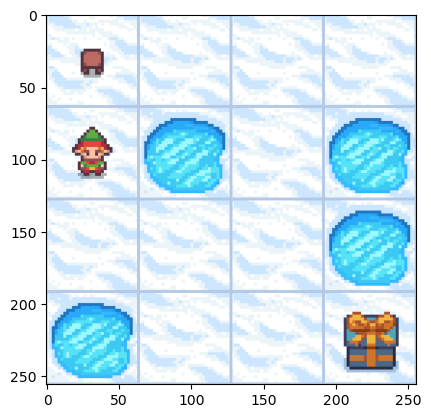

--------------------
obs: 4
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
=> TIMESTAMP [2]; EPISODE [1]<=
position: 4
saved observation: you are in position 4. You moved from position 0. Your last action was to go down.
generate_action
get_action_prompt: We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 4. You moved from position 0. Your last action was to go down.. What direction do you want to move in? (please provide only the direction name) If you are unsure, please output one of the directions listed before as you are learning how to play. 


Llama.generate: prefix-match hit


generated output: {'id': 'cmpl-5519841e-8580-4ac2-bbed-d39f5d4ab42c', 'object': 'text_completion', 'created': 1686081800, 'model': '../model/wizardLM-7B.ggmlv3.q4_1.bin', 'choices': [{'text': "We are testing if an AI language model can successfully play a video game. Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. You are located on the top left of the map and want to reach down right. You can move in the following directions: 'left', 'down', 'right', 'up'. This is your last observation about positioning in the game you are in position 4. You moved from position 0. Your last action was to go down.. What direction do you want to move in? (please provide only the direction name) If you are unsure, please output one of the directions listed before as you are learning how to play. \nAs an AI assistant, I can provide information and assistance on various topics, but I am not capable of playing video games or experiencing them like a human player would. Therefore,


llama_print_timings:        load time =  6907.03 ms
llama_print_timings:      sample time =    53.08 ms /    74 runs   (    0.72 ms per token)
llama_print_timings: prompt eval time =  3331.22 ms /    61 tokens (   54.61 ms per token)
llama_print_timings:        eval time =  3847.87 ms /    73 runs   (   52.71 ms per token)
llama_print_timings:       total time =  7590.49 ms


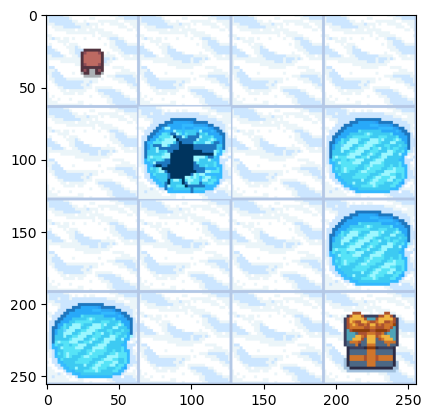

--------------------
obs: 5
reward: 0.0
terminated: True
truncated: False
info: {'prob': 1.0}
--------------------
Episode finished after 3 timesteps


In [8]:

rewards = []
observations = []
actions_taken = []
position_old = None

for i_episode in range(2):
    observation = env.reset()
    print(f"observation: {observation}")
    observations.append(observation)

    episode_reward = 0
    print(f"episode_reward: {episode_reward}")

    # Loop over t timesteps 
    for t in range(5):

        print(f"=> TIMESTAMP [{t}]; EPISODE [{i_episode}]<=")

        # Set position ot the last index in observations
        position = observations[-1][0]
        print(f"position: {position}")

        # Give the LLM some information about the current state of the game

        if (position_old is not None) and (position_old != position):
            # save observation
            agent.save_observation(f"you are in position {position}. You moved from position {position_old}. Your last action was to go {actions_taken[-1]}.")
        elif position_old is None:
        
            agent.save_observation(f"you are in position {position}. This is the start of the game.")
        else:
            # save observation
            agent.save_observation(f"you are still in position {position}. You did not move. Your last action was to go {actions_taken[-1]}.")
        
        
        
        # print(f"saved observation: you are in position {position}")

        # generate action
        action = agent.generate_action(debug=True)
        print("selected action", action)

        # take action
        # Within the game board state
        obs, reward, terminated, truncated, info = env.step(action)

        print("GENERATED ACTION: ", action_space[action])
        print("##################################################")
        # print("RENEDERED ACTION: ", env.render())
        #show the image of the render of the action
        plt.imshow(env.render())
        plt.show()


        print("--------------------")
        print(f"obs: {obs}")
        print(f"reward: {reward}")
        print(f"terminated: {terminated}")
        print(f"truncated: {truncated}")
        print(f"info: {info}")
        print("--------------------")

        observations.append((obs, info))

        # save reward
        agent.save_reward(reward)

        position_old = position

        actions_taken.append(action_space[action])

        # If the episode terminated prematurely, save the reward and stop the episode
        if terminated:
            print("Episode finished after {} timesteps".format(t+1))
            rewards.append(reward)
            break

        if t == 9:
            rewards.append(reward)



[0.0, 0.0]


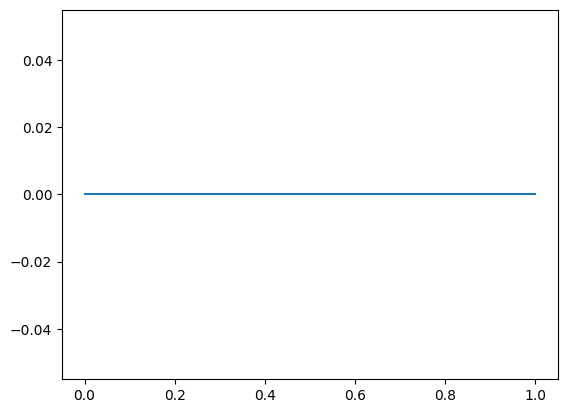

In [9]:
print(rewards)
plt.plot(rewards)